# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

In [5]:
from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field
from pysbmy.correlations import get_autocorrelation

## Setting up the environment

In [6]:
WORKDIR = "/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/"
SIMDIR = (
    "/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/"  # need not be on same disk
)

``params.py`` contains the configuration for this notebook and can be adjusted.

In [7]:
from tools import generate_sim_params
from params import (
    L0,
    L1,
    L2,
    corner0,
    corner1,
    corner2,
    N0,
    Np0,
    Npm0,
    cosmo,
    RedshiftLPT,
    RedshiftFCs,
    ai,
    af,
    cosmo_small_to_full_dict,
)

## Preparing the inputs

### Define the list of simulations to perform for this run

In [8]:
run_id = "run1"
force = False

# Parameters for the pm simulations
nsteps_pm_list = [20]  # , 30]

# Parameters for the cola simulations
nsteps_cola_list = [2, 5, 10]  # , 15]

# Parameters for the cola simulations
nsteps_bullfrog_list = [2, 5, 10]  # , 15]

In principle nothing needs to be changed below this cell.

In [9]:
wd = WORKDIR + run_id + "/"
simdir = SIMDIR + run_id + "/"
logdir = simdir + "logs/"
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

nsim_pm = len(nsteps_pm_list)
nsim_cola = len(nsteps_cola_list)
nsim_bullfrog = len(nsteps_bullfrog_list)

ICs_path = simdir + "initial_density.h5"
simpath = simdir

In [10]:
# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [11]:
common_params = {
    "Np0": Np0,
    "N0": N0,
    "L0": L0,
    "corner0": corner0,
    "corner1": corner1,
    "corner2": corner2,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file

pm_params = common_params.copy()
pm_params["method"] = "pm"
pm_params["TimeStepDistribution"] = 0
pm_params["ai"] = ai
pm_params["af"] = af
pm_params["RedshiftLPT"] = RedshiftLPT
pm_params["RedshiftFCs"] = RedshiftFCs
pm_params["Npm0"] = Npm0

cola_params = common_params.copy()
cola_params["method"] = "cola"
cola_params["TimeStepDistribution"] = 0
cola_params["ai"] = ai
cola_params["af"] = af
cola_params["RedshiftLPT"] = RedshiftLPT
cola_params["RedshiftFCs"] = RedshiftFCs
cola_params["Npm0"] = Npm0

bullfrog_params = common_params.copy()
bullfrog_params["method"] = "bullfrog"
bullfrog_params["TimeStepDistribution"] = 0
bullfrog_params["ai"] = ai
bullfrog_params["af"] = af
bullfrog_params["RedshiftLPT"] = RedshiftLPT
bullfrog_params["RedshiftFCs"] = RedshiftFCs
bullfrog_params["Npm0"] = Npm0

In [12]:
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

for i in range(nsim_pm):
    print(f"PM nsteps = {nsteps_pm_list[i]}:")
    pm_params["nsteps"] = nsteps_pm_list[i]
    file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
    generate_sim_params(pm_params, ICs_path, wd, simdir, file_ext, force)

for i in range(nsim_cola):
    print(f"COLA nsteps = {nsteps_cola_list[i]}:")
    cola_params["nsteps"] = nsteps_cola_list[i]
    file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
    generate_sim_params(cola_params, ICs_path, wd, simdir, file_ext, force)

for i in range(nsim_bullfrog):
    print(f"BULLFROG nsteps = {nsteps_bullfrog_list[i]}:")
    bullfrog_params["nsteps"] = nsteps_bullfrog_list[i]
    file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
    generate_sim_params(bullfrog_params, ICs_path, wd, simdir, file_ext, force)

> Generating parameter file...
[03:08:07|STATUS    ]|Writing parameter file in '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/example_lpt.sbmy'...
[03:08:07|STATUS    ]|Writing parameter file in '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/example_lpt.sbmy' done.
> Parameter file written to /data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/example_lpt.sbmy.
PM nsteps = 20:
> Generating time-stepping distribution...
[03:08:08|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/nsteps20_ts_pm.h5'...
[03:08:08|STATUS    ]|Write timestepping configuration in '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/nsteps20_ts_pm.h5' done.
> Generating parameter file...
[03:08:08|STATUS    ]|Writing parameter file in '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_params/run1/nsteps20_example_pm.sbmy'...
[03:08:08|STATU

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [13]:
# If cosmo["WhichSpectrum"] == "class", then the module classy is
# required.
if not isfile(input_power_file):
    Pk = PowerSpectrum(L0, L1, L2, N0, N0, N0, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[03:08:08|STATUS    ]|Setting up Fourier grid...
[03:08:08|STATUS    ]|Setting up Fourier grid done.
[03:08:08|STATUS    ]|Computing normalization of the power spectrum...
[03:08:08|DIAGNOSTIC]==|Norm=3079585.435515
[03:08:08|DIAGNOSTIC]==|sigma8=0.815900
[03:08:08|STATUS    ]|Computing normalization of the power spectrum done.
[03:08:08|STATUS    ]|Computing power spectrum...
[03:08:08|DIAGNOSTIC]==|(float *)k_modes=[0 0.0251327 0.0355431 0.0435312 0.0502655 0.0561985 0.0615624 0.0710861 0.0753982 0.0794767 0.0833559 0.0870624 0.0906174 0.0940381 0.100531 0.103625 0.106629 0.109551 0.112397 0.115173 0.117883 0.123125 0.125664 0.128152 0.130594 0.135344 0.137658 0.142172 0.144377 0.146548 0.148687 0.150796 0.152876 0.154929 0.158953 0.160928 0.162879 0.164806 0.166712 0.168596 0.170459 0.174125 0.175929 0.177715 0.179484 0.181235 0.182969 0.184687 0.188076 0.189748 0.191405 0.193048 0.196293 0.197895 0.201062 0.202627 0.204179 0.20572 0.20725 0.208768 0.210276 0.213258 0.214734 0.2162 

In [14]:
kmin = 0.0
kmax = 1.0
Nk = 64
k_modes = np.linspace(kmin, kmax, Nk + 1)[:-1]
input_ss_file = simdir + "input_ss_k_grid.h5"
if not isfile(input_ss_file):
    Gk = FourierGrid(L0, L1, L2, N0, N0, N0, k_modes=k_modes, kmax=kmax)
    Gk.write(input_ss_file)

[03:08:08|STATUS    ]|Setting up Fourier grid...
[03:08:08|STATUS    ]|Setting up Fourier grid done.
[03:08:08|STATUS    ]|Write Fourier grid in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/input_ss_k_grid.h5'...
[03:08:08|DIAGNOSTIC]==|L0=250.0, L1=250.0, L2=250.0
[03:08:08|DIAGNOSTIC]==|N0=128, N1=128, N2=128, N2_HC=65, N_HC=1064960, NUM_MODES=64
[03:08:08|STATUS    ]|Write Fourier grid in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/input_ss_k_grid.h5' done.


## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable. Warning: the following may take some time, even in relatively low dimension, and should not be run on a login node.

In [15]:
%%capture

if not isfile(ICs_path) or not isfile(simdir + "lpt_density.h5") or not isfile(simdir + "lpt_particles.gadget3"):
    !simbelmyne {wd}example_lpt.sbmy {logdir}lpt.txt

for i in range(nsim_pm):
    file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
    if not isfile(simdir + f"{file_ext}_final_density_pm.h5"):
        !simbelmyne {wd}{file_ext}_example_pm.sbmy {logdir}{file_ext}_pm.txt

for i in range(nsim_cola):
    file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
    if not isfile(simdir + f"{file_ext}_final_density_cola.h5"):
        !simbelmyne {wd}{file_ext}_example_cola.sbmy {logdir}{file_ext}_cola.txt

for i in range(nsim_bullfrog):
    file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
    if not isfile(simdir + f"{file_ext}_final_density_bullfrog.h5"):
        !simbelmyne {wd}{file_ext}_example_bullfrog.sbmy {logdir}{file_ext}_bullfrog.txt

The logs can be live-monitored in the corresponding files in the `logdir` directory.

## Results

In [16]:
from plot_utils import *

### Density fields

[03:10:20|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/lpt_density.h5'...
[03:10:20|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(128), np.int32(128), np.int32(128)]
[03:10:20|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/lpt_density.h5' done.
[03:10:21|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/nsteps20_final_density_pm.h5'...
[03:10:21|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(128), np.int32(128), np.int32(128)]
[03:10:21|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/nsteps20_final_density_pm.h5' done.
[03:10:21|STATUS    ]|Read field i

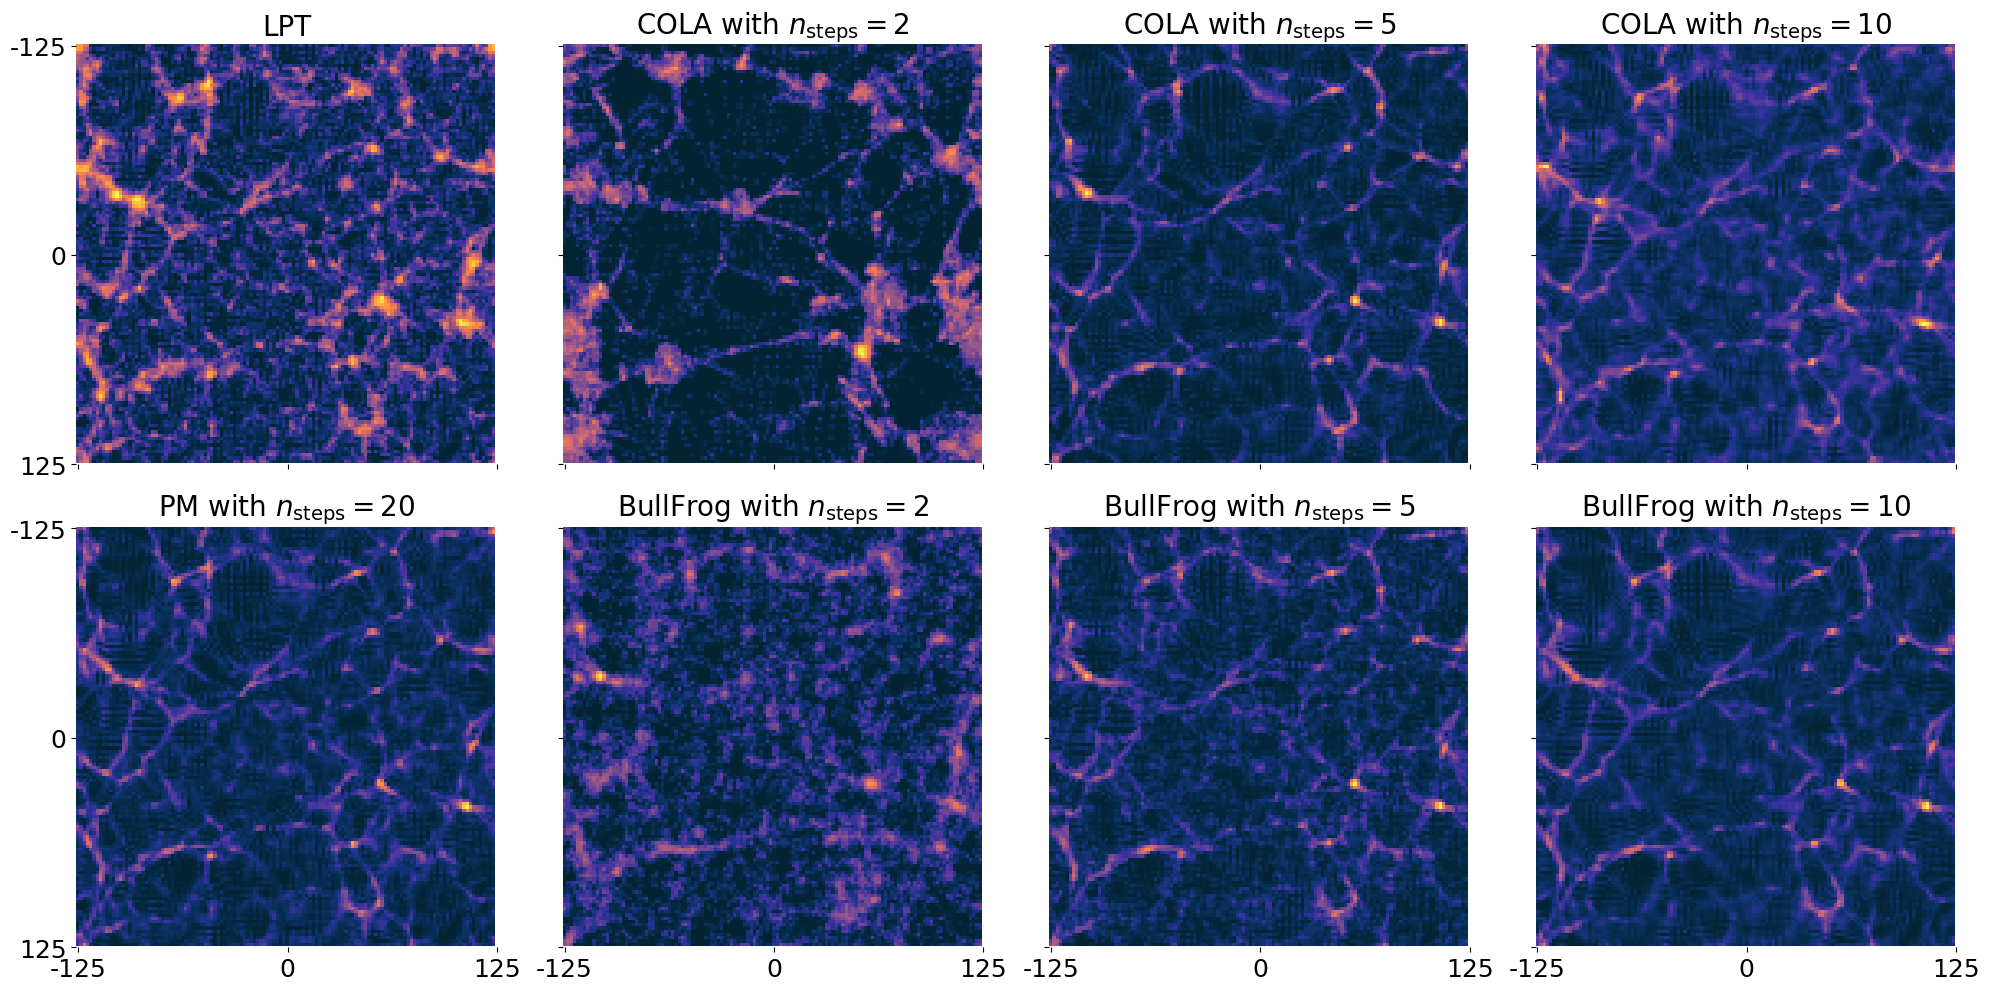

In [17]:
slice_ijk = (N0//2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0,i+1].imshow(np.log(2+DELTA_COLA), cmap=cmap)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[slice_ijk]
        axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap)
        axs[1,i+1].set_title(f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:,0]:
    ax.set_yticks([0, N0//2, N0])
    ax.set_yticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for ax in axs[1,:]:
    ax.set_xticks([0, N0//2, N0])
    ax.set_xticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i,j].get_title() == "":
            axs[i,j].axis("off")
plt.tight_layout()
plt.show()

### Computing and plotting final power spectra

In [18]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
    Sk_PM = np.sqrt(Vk_PM)
    Pk_PM_list.append(Pk_PM)
    Sk_PM_list.append(Sk_PM)

Pk_ref = Pk_PM_list[-1]

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
    Sk_COLA = np.sqrt(Vk_COLA)
    Pk_COLA_list.append(Pk_COLA)
    Sk_COLA_list.append(Sk_COLA)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
    Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
    Pk_BULLFROG_list.append(Pk_BULLFROG)
    Sk_BULLFROG_list.append(Sk_BULLFROG)

[03:10:22|STATUS    ]|Read Fourier grid in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/input_ss_k_grid.h5'...
[03:10:22|DIAGNOSTIC]==|L0=250.0, L1=250.0, L2=250.0
[03:10:22|DIAGNOSTIC]==|N0=128, N1=128, N2=128, N2_HC=65, N_HC=1064960, NUM_MODES=64
[03:10:22|STATUS    ]|Read Fourier grid in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/input_ss_k_grid.h5' done.
[03:10:22|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/initial_density.h5'...
[03:10:22|DIAGNOSTIC]==|ranges=[np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.float64(-125.0), np.float64(125.0), np.int32(128), np.int32(128), np.int32(128)]
[03:10:22|STATUS    ]|Read field in data file '/data101/hoellinger/AquilaGit/simbelmyne_private/tests/runs_sims/run1/initial_density.h5' done.
[03:10:22|STATUS    ]|Getting auto-correlation in Fourier space (using 32 cores)...
[03:

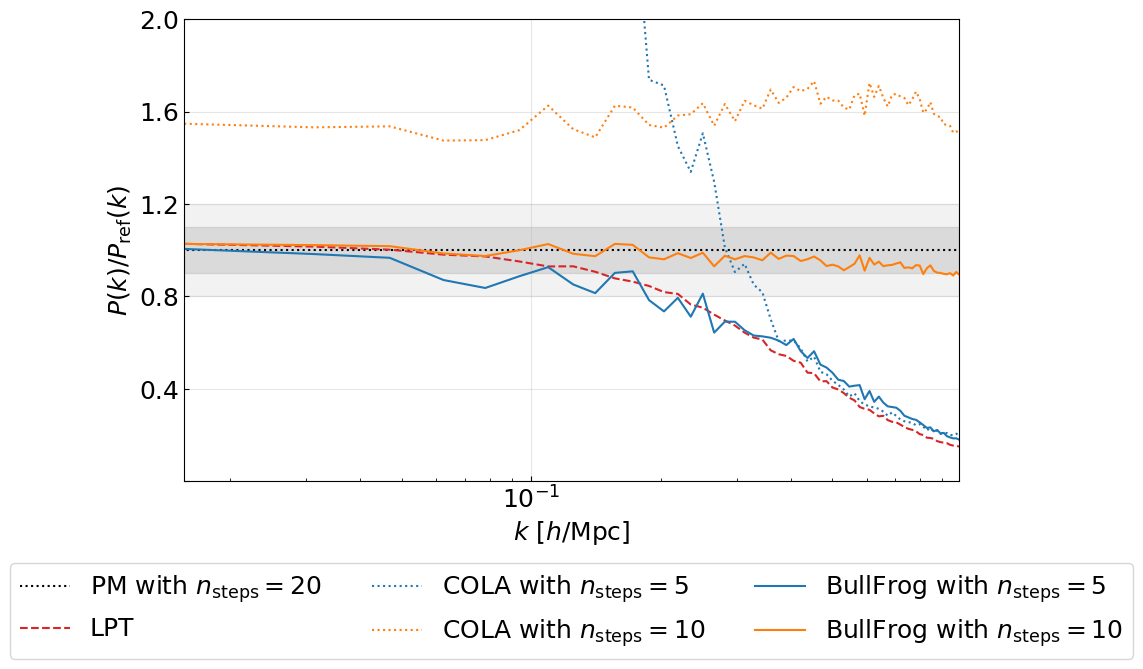

In [19]:
common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > 2]
nlines = len(common_nsteps) + 2

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
k = G.k_modes[1:]
ax.set_xlim([k.min(), k.max()])
ax.set_ylim([0, 2])  # to be adjusted depending on the setup

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
# ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
ax.plot(k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--")
for i, nsteps in enumerate(nsteps_pm_list[:-1]):
    ax.plot(
        k,
        Pk_PM_list[i] / Pk_ref,
        label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="--",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i] / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i] / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )
bnd1 = 0.1  # to be adjusted depending on the setup
bnd2 = 0.2  # to be adjusted depending on the setup
ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

ax.grid(alpha=0.3)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=fs)

plt.show()